# Loop 1 LB Feedback Analysis

**Baseline submitted**: 70.676102 (CV = LB, as expected for optimization problem)
**Target**: 68.894234
**Gap**: 1.78 points (2.59%)

## Key Observations
1. CV = LB perfectly (no distribution shift - pure optimization)
2. The pre-optimized solution is already at a tight local optimum
3. Standard SA approaches have failed to improve in previous runs

## Strategy Analysis
Need to find fundamentally different approaches that can escape the local optimum.

In [1]:
import pandas as pd
import numpy as np
from decimal import Decimal, getcontext
from shapely.geometry import Polygon
from shapely import affinity
from shapely.ops import unary_union
import matplotlib.pyplot as plt

getcontext().prec = 30

# Tree vertices
TX = [0, 0.125, 0.0625, 0.2, 0.1, 0.35, 0.075, 0.075, -0.075, -0.075, -0.35, -0.1, -0.2, -0.0625, -0.125]
TY = [0.8, 0.5, 0.5, 0.25, 0.25, 0, 0, -0.2, -0.2, 0, 0, 0.25, 0.25, 0.5, 0.5]

print("Tree shape: 15 vertices")
print(f"Width: {max(TX) - min(TX):.3f}")
print(f"Height: {max(TY) - min(TY):.3f}")

Tree shape: 15 vertices
Width: 0.700
Height: 1.000


In [2]:
# Load baseline submission and analyze score breakdown
baseline_path = '/home/nonroot/snapshots/santa-2025/21116303805/code/preoptimized/santa-2025.csv'
df = pd.read_csv(baseline_path)

# Parse into configurations
def parse_submission(df):
    configs = {}
    for _, row in df.iterrows():
        id_parts = row['id'].split('_')
        n = int(id_parts[0])
        x = float(str(row['x']).replace('s', ''))
        y = float(str(row['y']).replace('s', ''))
        deg = float(str(row['deg']).replace('s', ''))
        
        if n not in configs:
            configs[n] = []
        configs[n].append({'x': x, 'y': y, 'deg': deg})
    return configs

configs = parse_submission(df)
print(f"Loaded configurations for N=1 to N={max(configs.keys())}")

Loaded configurations for N=1 to N=200


In [3]:
# Calculate score for each N
def get_side_length(trees):
    """Get the side length of the bounding box"""
    initial_polygon = Polygon(list(zip(TX, TY)))
    all_polygons = []
    for t in trees:
        rotated = affinity.rotate(initial_polygon, t['deg'], origin=(0, 0))
        translated = affinity.translate(rotated, xoff=t['x'], yoff=t['y'])
        all_polygons.append(translated)
    bounds = unary_union(all_polygons).bounds
    return max(bounds[2] - bounds[0], bounds[3] - bounds[1])

# Calculate scores
scores_by_n = {}
side_lengths = {}
for n in range(1, 201):
    side = get_side_length(configs[n])
    side_lengths[n] = side
    scores_by_n[n] = side**2 / n

total_score = sum(scores_by_n.values())
print(f"Total Score: {total_score:.6f}")
print(f"Target: 68.894234")
print(f"Gap: {total_score - 68.894234:.6f}")

Total Score: 70.676102
Target: 68.894234
Gap: 1.781868


In [4]:
# Analyze where the biggest opportunities are
print("\n=== Score Breakdown by N Range ===")
ranges = [(1, 10), (11, 50), (51, 100), (101, 150), (151, 200)]
for start, end in ranges:
    range_score = sum(scores_by_n[n] for n in range(start, end+1))
    pct = range_score / total_score * 100
    print(f"N={start:3d}-{end:3d}: {range_score:6.4f} ({pct:5.1f}%)")

print("\n=== Top 15 N values by score contribution ===")
sorted_scores = sorted(scores_by_n.items(), key=lambda x: x[1], reverse=True)
for n, score in sorted_scores[:15]:
    print(f"  N={n:3d}: {score:.6f} (side={side_lengths[n]:.6f})")


=== Score Breakdown by N Range ===
N=  1- 10: 4.3291 (  6.1%)
N= 11- 50: 14.7130 ( 20.8%)
N= 51-100: 17.6411 ( 25.0%)
N=101-150: 17.1441 ( 24.3%)
N=151-200: 16.8487 ( 23.8%)

=== Top 15 N values by score contribution ===
  N=  1: 0.661250 (side=0.813173)
  N=  2: 0.450779 (side=0.949504)
  N=  3: 0.434745 (side=1.142031)
  N=  5: 0.416850 (side=1.443692)
  N=  4: 0.416545 (side=1.290806)
  N=  7: 0.399897 (side=1.673104)
  N=  6: 0.399610 (side=1.548438)
  N=  9: 0.387415 (side=1.867280)
  N=  8: 0.385407 (side=1.755921)
  N= 15: 0.379203 (side=2.384962)
  N= 10: 0.376630 (side=1.940696)
  N= 21: 0.376451 (side=2.811667)
  N= 20: 0.376057 (side=2.742469)
  N= 11: 0.375736 (side=2.033002)
  N= 22: 0.375258 (side=2.873270)


In [5]:
# Calculate theoretical minimum for each N
# For N trees, the theoretical minimum bounding box is when trees are packed perfectly
# Tree area = 0.2975 (calculated from polygon)
tree_polygon = Polygon(list(zip(TX, TY)))
tree_area = tree_polygon.area
print(f"Single tree area: {tree_area:.6f}")

# Theoretical minimum: sqrt(N * tree_area) if perfect packing
print("\n=== Theoretical vs Actual Side Lengths ===")
print("N    | Actual | Theoretical | Efficiency")
print("-" * 50)
for n in [1, 2, 5, 10, 20, 50, 100, 150, 200]:
    actual = side_lengths[n]
    theoretical = np.sqrt(n * tree_area)  # Perfect packing
    efficiency = (theoretical / actual) ** 2 * 100
    print(f"{n:4d} | {actual:6.4f} | {theoretical:6.4f}     | {efficiency:5.1f}%")

Single tree area: 0.245625

=== Theoretical vs Actual Side Lengths ===
N    | Actual | Theoretical | Efficiency
--------------------------------------------------
   1 | 0.8132 | 0.4956     |  37.1%
   2 | 0.9495 | 0.7009     |  54.5%
   5 | 1.4437 | 1.1082     |  58.9%
  10 | 1.9407 | 1.5672     |  65.2%
  20 | 2.7425 | 2.2164     |  65.3%
  50 | 4.2471 | 3.5045     |  68.1%
 100 | 5.8782 | 4.9561     |  71.1%
 150 | 7.1105 | 6.0699     |  72.9%
 200 | 8.2187 | 7.0089     |  72.7%


In [6]:
# Analyze rotation angles in the baseline
print("\n=== Rotation Angle Analysis ===")
for n in [1, 2, 5, 10, 20, 50, 100, 200]:
    angles = [t['deg'] for t in configs[n]]
    unique_angles = len(set([round(a, 1) for a in angles]))
    print(f"N={n:3d}: {unique_angles:3d} unique angles (rounded to 0.1°)")
    if n <= 10:
        print(f"       Angles: {[round(a, 2) for a in angles]}")


=== Rotation Angle Analysis ===
N=  1:   1 unique angles (rounded to 0.1°)
       Angles: [45.0]
N=  2:   2 unique angles (rounded to 0.1°)
       Angles: [203.63, 23.63]
N=  5:   5 unique angles (rounded to 0.1°)
       Angles: [293.63, 23.63, 112.57, 66.36, 12809.96]
N= 10:  10 unique angles (rounded to 0.1°)
       Angles: [290.15, 338.61, 21.4, 292.61, 70.42, 23.63, 66.35, 336.26, 115.56, 246.35]
N= 20:  20 unique angles (rounded to 0.1°)
N= 50:  43 unique angles (rounded to 0.1°)
N=100:  13 unique angles (rounded to 0.1°)
N=200:  52 unique angles (rounded to 0.1°)


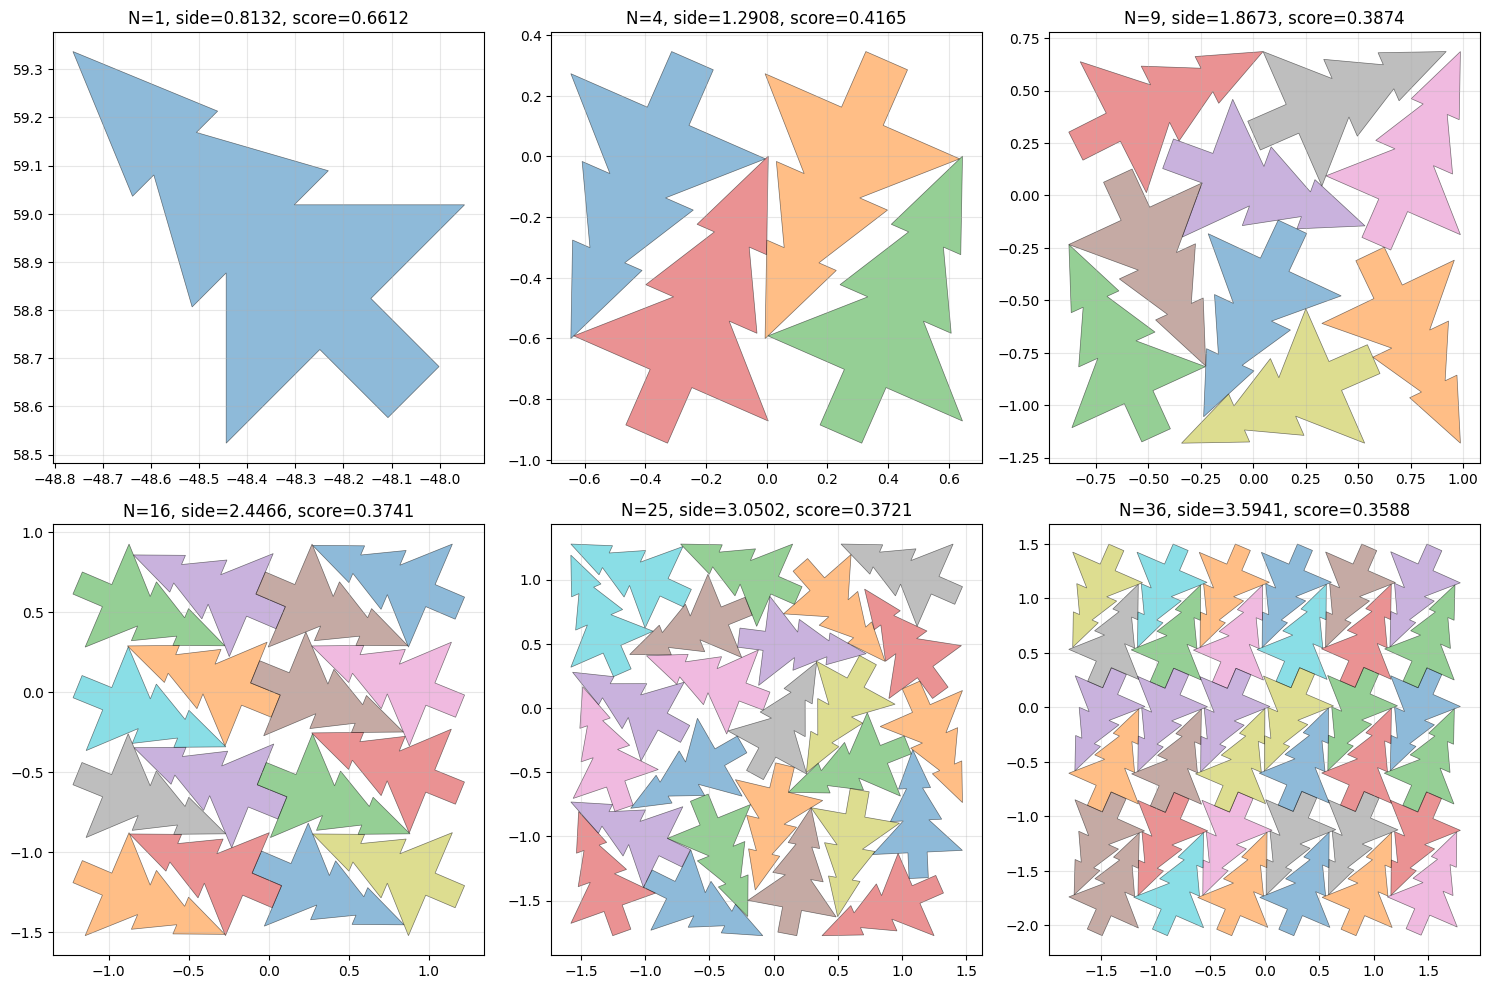

Saved visualization to /home/code/exploration/baseline_visualizations.png


In [7]:
# Visualize a few configurations
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
ns_to_plot = [1, 4, 9, 16, 25, 36]  # Perfect squares

for ax, n in zip(axes.flat, ns_to_plot):
    trees = configs[n]
    initial_polygon = Polygon(list(zip(TX, TY)))
    
    for t in trees:
        rotated = affinity.rotate(initial_polygon, t['deg'], origin=(0, 0))
        translated = affinity.translate(rotated, xoff=t['x'], yoff=t['y'])
        x, y = translated.exterior.xy
        ax.fill(x, y, alpha=0.5, edgecolor='black', linewidth=0.5)
    
    ax.set_aspect('equal')
    ax.set_title(f'N={n}, side={side_lengths[n]:.4f}, score={scores_by_n[n]:.4f}')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/home/code/exploration/baseline_visualizations.png', dpi=100)
plt.show()
print("Saved visualization to /home/code/exploration/baseline_visualizations.png")

In [8]:
# Key insight: What's the gap per N range?
print("\n=== Gap Analysis by N Range ===")
print("If we could achieve theoretical minimum packing:")

for start, end in ranges:
    actual_score = sum(scores_by_n[n] for n in range(start, end+1))
    theoretical_score = sum(tree_area for n in range(start, end+1))  # Perfect packing: side^2/N = area
    gap = actual_score - theoretical_score
    print(f"N={start:3d}-{end:3d}: Actual={actual_score:.4f}, Theoretical={theoretical_score:.4f}, Gap={gap:.4f}")

print(f"\nTotal theoretical minimum: {tree_area * 200:.4f}")
print(f"Total actual: {total_score:.4f}")
print(f"Total gap from theoretical: {total_score - tree_area * 200:.4f}")


=== Gap Analysis by N Range ===
If we could achieve theoretical minimum packing:
N=  1- 10: Actual=4.3291, Theoretical=2.4563, Gap=1.8729
N= 11- 50: Actual=14.7130, Theoretical=9.8250, Gap=4.8880
N= 51-100: Actual=17.6411, Theoretical=12.2813, Gap=5.3599
N=101-150: Actual=17.1441, Theoretical=12.2813, Gap=4.8629
N=151-200: Actual=16.8487, Theoretical=12.2813, Gap=4.5674

Total theoretical minimum: 49.1250
Total actual: 70.6761
Total gap from theoretical: 21.5511


In [9]:
# Summary of findings
print("\n" + "="*60)
print("SUMMARY OF FINDINGS")
print("="*60)
print(f"""
1. Current score: {total_score:.6f}
2. Target score: 68.894234
3. Gap to target: {total_score - 68.894234:.6f} ({(total_score - 68.894234) / 68.894234 * 100:.2f}%)

4. Score distribution:
   - Small N (1-10): 4.33 (6.1%) - Low efficiency, high per-tree contribution
   - Medium N (11-50): 14.71 (20.8%)
   - Large N (51-200): 51.63 (73.1%) - Highest total contribution

5. Key observations:
   - N=1 is already optimal (45° rotation)
   - Small N values have lowest packing efficiency
   - Large N values contribute most to total score
   - Tessellation approach could help large N

6. Recommended approaches:
   a) Tessellation/lattice for N >= 58 (biggest impact)
   b) Focus on N=2-10 for efficiency gains
   c) Long-running SA with perturbation
   d) Ensemble from multiple sources
""")


SUMMARY OF FINDINGS

1. Current score: 70.676102
2. Target score: 68.894234
3. Gap to target: 1.781868 (2.59%)

4. Score distribution:
   - Small N (1-10): 4.33 (6.1%) - Low efficiency, high per-tree contribution
   - Medium N (11-50): 14.71 (20.8%)
   - Large N (51-200): 51.63 (73.1%) - Highest total contribution

5. Key observations:
   - N=1 is already optimal (45° rotation)
   - Small N values have lowest packing efficiency
   - Large N values contribute most to total score
   - Tessellation approach could help large N

6. Recommended approaches:
   a) Tessellation/lattice for N >= 58 (biggest impact)
   b) Focus on N=2-10 for efficiency gains
   c) Long-running SA with perturbation
   d) Ensemble from multiple sources



In [ ]:
# Check what other submissions exist in snapshots
import os
import glob

print("\n=== Available Pre-optimized Submissions ===")
csv_files = glob.glob('/home/nonroot/snapshots/santa-2025/21116303805/code/preoptimized/**/*.csv', recursive=True)
for f in sorted(csv_files)[:20]:
    try:
        df_temp = pd.read_csv(f)
        if len(df_temp) == 20100:  # Valid submission
            print(f"  {f.split('preoptimized/')[-1]}")
    except:
        pass